In [1]:
from activ import load_data, data_normalization
import os
from activ.readfile import TrackTBIFile
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap, nmf_bases_heatmap, nmf_heatmap, nmf_boxplot
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as _sch
from matplotlib.backends.backend_pdf import PdfPages

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
file = '/Users/ahyeon/Desktop/activ misc/sweep_u2-10_c2-50_i50_raw-oc-cluster_uoinmf-bm-predict/umap_clustering_sweep.h5'
f = h5py.File(file, 'r')
umap_dims = f['umap_dimensions'][:]
emb = f['umap_embeddings'][:]
scale = f['umap_embeddings_dimscale'][:][:54]
emb.shape

(50, 247, 54)

In [22]:
for dim in umap_dims:
    all_dmat = np.zeros((30381,50))
    for x in range(emb.shape[0]):
        dmat = pdist(emb[x][:,scale==dim], metric='euclidean')
        all_dmat[:,x] = dmat
    mean = all_dmat.mean(axis=1)
mean.shape

(30381,)

In [23]:
numclusters = 27
labels = _sch.cut_tree(_sch.linkage(mean, method='ward'), numclusters)
nmfdata = load_data(uoinmf=True)
nmf_oc_weights = nmfdata.outcomes
nmf_bm_weights = nmfdata.biomarkers

oc_avg_weights = np.zeros((numclusters, nmf_oc_weights.shape[1]))
bm_avg_weights = np.zeros((numclusters, nmf_bm_weights.shape[1]))
for x in range(numclusters):
    indices = []
    for j in range(len(labels)):
        if labels[j]==x:
            indices.append(j)
    values_oc = []
    values_bm = []
    for i in indices:
        val_oc = nmf_oc_weights[i,:]
        val_bm = nmf_bm_weights[i,:]
        values_oc.append(val_oc)
        values_bm.append(val_bm)
    oc_avg_weights[x,:] = np.mean(values_oc, axis=0)
    bm_avg_weights[x,:] = np.mean(values_bm, axis=0)

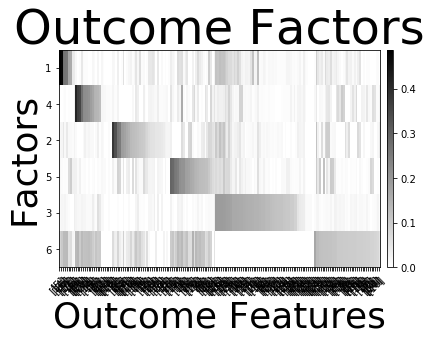

In [24]:
pdf = PdfPages("/Users/ahyeon/Desktop/activ misc/outcome_weights_structure.pdf")
nmf_bases_heatmap(nmfdata.outcome_bases, col_labels=labels, sort=True, ax=None,
            cbar_kw={}, cbarlabel="", xlab='Outcome Features', ylab='Factors', aspect='auto',
            title='Outcome Factors')
pdf.savefig()

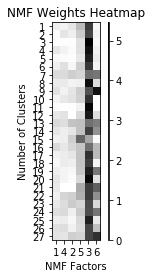

In [25]:
nmf_heatmap(oc_avg_weights, np.array([0,3,1,4,2,5]), 27)
pdf.savefig()

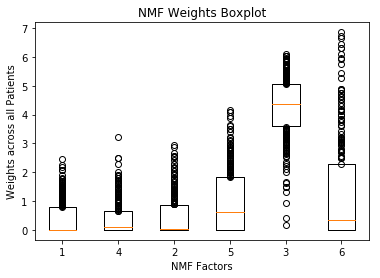

In [26]:
nmf_boxplot(nmf_oc_weights, [0,3,1,4,2,5])
pdf.savefig()
pdf.close()

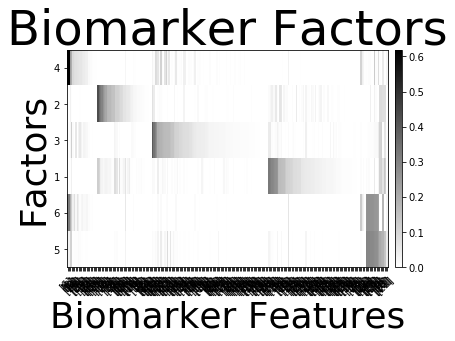

In [35]:
pdf = PdfPages("/Users/ahyeon/Desktop/activ misc/biomarker_weights_structure.pdf")
nmf_bases_heatmap(nmfdata.biomarker_bases, col_labels=labels, sort=True, ax=None,
            cbar_kw={}, cbarlabel="", xlab='Biomarker Features', ylab='Factors', aspect='auto',
            title='Biomarker Factors')
pdf.savefig()

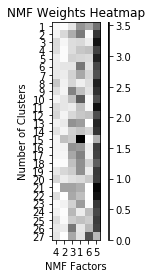

In [36]:
nmf_heatmap(bm_avg_weights, np.array([3,1,2,0,5,4]), 27)
pdf.savefig()

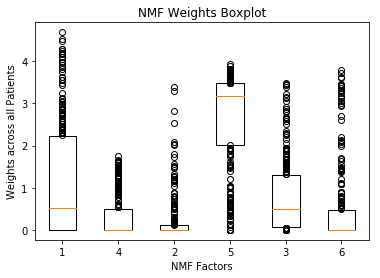

In [37]:
nmf_boxplot(nmf_bm_weights, [0,3,1,4,2,5])
pdf.savefig()
pdf.close()